In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import os
torch.cuda.set_per_process_memory_fraction(0.8, 0)
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [2]:
batch_size = 8
epochs = 5
workers = 0 if os.name == 'nt' else 8

In [3]:
model = InceptionResnetV1(pretrained='vggface2').eval()

In [4]:
from torchsummary import summary 
count=0
for param in model.parameters():
    if count<=374:
        param.requires_grad = False
    count+=1
for name, param in model.named_parameters():
    if param.requires_grad:print(name)
summary(model, (3,160,160))
# del model

last_linear.weight
last_bn.weight
last_bn.bias
logits.weight
logits.bias
Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 79, 79]          --
|    └─Conv2d: 2-1                       [-1, 32, 79, 79]          (864)
|    └─BatchNorm2d: 2-2                  [-1, 32, 79, 79]          (64)
|    └─ReLU: 2-3                         [-1, 32, 79, 79]          --
├─BasicConv2d: 1-2                       [-1, 32, 77, 77]          --
|    └─Conv2d: 2-4                       [-1, 32, 77, 77]          (9,216)
|    └─BatchNorm2d: 2-5                  [-1, 32, 77, 77]          (64)
|    └─ReLU: 2-6                         [-1, 32, 77, 77]          --
├─BasicConv2d: 1-3                       [-1, 64, 77, 77]          --
|    └─Conv2d: 2-7                       [-1, 64, 77, 77]          (18,432)
|    └─BatchNorm2d: 2-8                  [-1, 64, 77, 77]          (128)
|    └─ReLU: 2-9                         [-1, 64, 77, 77]    

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 79, 79]          --
|    └─Conv2d: 2-1                       [-1, 32, 79, 79]          (864)
|    └─BatchNorm2d: 2-2                  [-1, 32, 79, 79]          (64)
|    └─ReLU: 2-3                         [-1, 32, 79, 79]          --
├─BasicConv2d: 1-2                       [-1, 32, 77, 77]          --
|    └─Conv2d: 2-4                       [-1, 32, 77, 77]          (9,216)
|    └─BatchNorm2d: 2-5                  [-1, 32, 77, 77]          (64)
|    └─ReLU: 2-6                         [-1, 32, 77, 77]          --
├─BasicConv2d: 1-3                       [-1, 64, 77, 77]          --
|    └─Conv2d: 2-7                       [-1, 64, 77, 77]          (18,432)
|    └─BatchNorm2d: 2-8                  [-1, 64, 77, 77]          (128)
|    └─ReLU: 2-9                         [-1, 64, 77, 77]          --
├─MaxPool2d: 1-4                         [-1, 64, 38, 38]       

In [5]:
class SiameseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.dataset= self.create_dataset(self.root_dir)        
        self.transform = transform
        self.no_of_people = len(list(self.dataset.keys()))
        self.min_length = min([len(self.dataset[i]) for i in self.dataset.keys()])
    
    def __len__(self):
        return self.min_length
    
    def __getitem__(self, idx=0):
        people = list(self.dataset.keys())
        person = people[random.randrange(self.no_of_people)]
        anchor_index = random.randint(0, len(self.dataset[person])-1)
        a = self.get_image(person, anchor_index)
        positive_index = random.randint(0, len(self.dataset[person])-1)
        while positive_index == anchor_index:
            positive_index = random.randint(0, len(self.dataset[person])-1)
        p = self.get_image(person, positive_index)
        people.remove(person)
        negative_person = random.choice(people)
        negative_index = random.randint(
            0, len(self.dataset[negative_person])-1)
        n = self.get_image(negative_person, negative_index)
        return a,p,n
        
        
    def create_dataset(self, dataset_path):
        dataset = {}
        for root, directories, files in os.walk(dataset_path):
            for directory in directories:
                for _, __, file in os.walk(os.path.join(dataset_path, directory)):
                    dataset[directory] = file
        return dataset
    
    def get_image(self, person, index):
        img = os.path.join(self.root_dir, os.path.join(
            person, self.dataset[person][index]))
        img = Image.open(img)
        img = img.resize((160,160))
        img = self.transform(img)
        return img
    
transformations = transforms.Compose(
    [transforms.ToTensor()])

dataSize = int(SiameseDataset('./data/data/').min_length)
TRAIN_PCT = 0.8 
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size

siameseDataset = SiameseDataset('./data/data/', transformations)

train_set, val_set = random_split(siameseDataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=8, num_workers=workers)
val_loader = DataLoader(val_set, batch_size=1, num_workers=workers, shuffle=True)

torch.Size([3, 160, 160]) torch.Size([3, 160, 160]) torch.Size([3, 160, 160])
torch.Size([3, 160, 160]) torch.Size([3, 160, 160]) torch.Size([3, 160, 160])
torch.Size([3, 160, 160]) torch.Size([3, 160, 160]) torch.Size([3, 160, 160])
torch.Size([3, 160, 160]) torch.Size([3, 160, 160]) torch.Size([3, 160, 160])


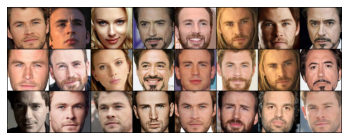

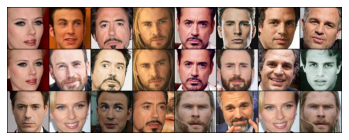

In [6]:
for i in range(len(siameseDataset)):
    sample = siameseDataset[i]
    print(sample[0].shape,sample[1].shape,sample[2].shape)
    if i == 3:
        break

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
for i in range(0,2):
    dataiter = iter(train_loader)
    example_batch = next(dataiter)
    concatenated = torch.cat((example_batch[0],example_batch[1], example_batch[2]),0)
    imshow(make_grid(concatenated))

In [7]:
class SiameseNetwork(torch.nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.facenet = model
        
    def forward_once(self, x):
        # Forward pass 
        output = self.facenet(x)
        return output

    def forward(self, input1, input2, input3):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3        

In [8]:
siamesenet = SiameseNetwork().cuda()
triplet_loss = torch.nn.TripletMarginLoss(margin=1.0)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
# count_parameters(siamesenet)
# summary(siamesenet, ((3,160,160),(3,160,160),(3,160,160)))

In [ ]:
optimizer = torch.optim.Adam(siamesenet.parameters(), lr=1e-4)
def train():
    counter = []
    loss_history = [] 
    train_losses = []
    val_losses = []
    iteration_number= 0
    
    for epoch in range(0,20):
        for i, data in enumerate(train_loader,0):
            img0, img1 , img3 = data
            img0, img1 , img3 = img0.cuda(), img1.cuda() , img3.cuda()
            optimizer.zero_grad()
            output1,output2,output3 = siamesenet(img0,img1,img3)
            loss = triplet_loss(output1,output2,output3)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
#             if i %50 == 0 :
        print("Epoch number {}\n Train loss {}\n".format(epoch,loss.item()))
#             iteration_number +=10
#             counter.append(iteration_number)
#             train_losses.append(loss.item())
                
        with torch.no_grad():
            siamesenet.eval()
            for i, data in enumerate(val_loader,0):
                img0, img1 , img3 = data
                img0, img1 , img3 = img0.cuda(), img1.cuda() , img3.cuda()
                output1,output2,output3 = siamesenet(img0,img1,img3)
                loss = triplet_loss(output1,output2,output3)
                val_losses.append(loss.item())
            print("Epoch number {}\n Vall loss {}\n".format(epoch,loss.item()))
#                 val_losses.append(loss.item())
    return siamesenet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

In [ ]:
# Save the entire model 
torch.save(model, 'Siamese_Facenet.pt')

In [9]:
model = SiameseNetwork().cuda()
model.load_state_dict(torch.load("model1.pt"))

<All keys matched successfully>

0.3831390142440796 1.542572021484375


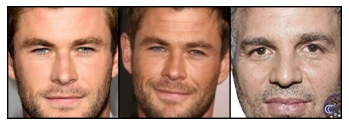

0.5423650145530701 1.5009897947311401


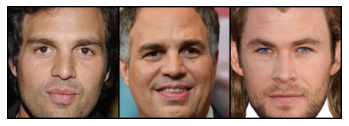

0.6288842558860779 1.2109098434448242


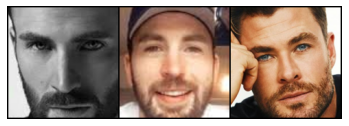

0.4035130739212036 1.6686673164367676


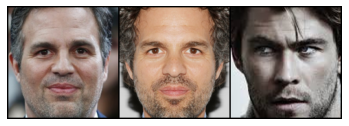

0.5016624331474304 1.6332746744155884


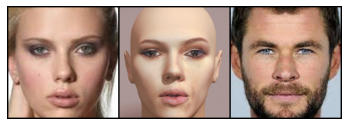

0.4513283967971802 1.7271934747695923


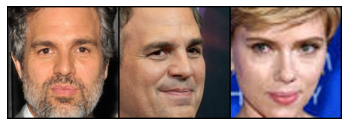

0.9691748023033142 1.4099361896514893


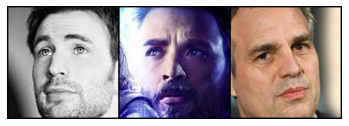

0.5354415774345398 1.7550572156906128


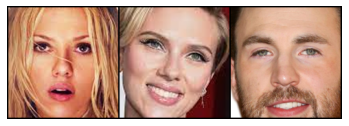

0.6106511354446411 1.707513451576233


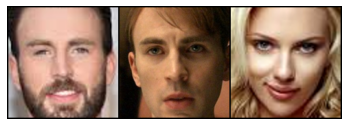

0.5030123591423035 1.1817052364349365


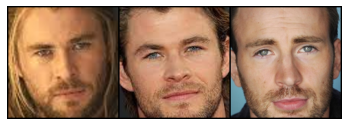

In [10]:
test_dataset = SiameseDataset('./data/data/', transformations)
test_dataloader = DataLoader(val_set, batch_size=1, num_workers=workers, shuffle=True)
for i in range(0,10):
    dataiter = iter(test_dataloader)
    example_batch = next(dataiter)
    concatenated = torch.cat((example_batch[0],example_batch[1], example_batch[2]),0)
#     print(example_batch[1], example_batch[2])
    output1,output2,output3 = model(example_batch[0].cuda(),example_batch[1].cuda(), example_batch[2].cuda())
    dis1 = torch.nn.functional.pairwise_distance(output1,output2)
    dis2 = torch.nn.functional.pairwise_distance(output1,output3)
    print(dis1.item(), dis2.item())
    imshow(make_grid(concatenated))

In [ ]:
Saved = torch.load('Siamese_Facenet.pt')
Saved.eval()